In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

sys.path.insert(0,'..')
%matplotlib inline

In [2]:
from dataset import Dataset
from base import NP

from train import Trainer
from utils.misc import Logger
from utils.dataset_utils import (load_data,train_test_split, make_features)

/Users/d3sm0/.virtualenvs/ntsa/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from config import trainconfig, parserconfig, np_config

In [4]:
from types import SimpleNamespace

In [5]:
trainconfig.update(parserconfig)
trainconfig.update(np_config)
config = SimpleNamespace(**trainconfig)

In [6]:
df = pd.read_pickle('../data/sml.pkl')

In [7]:
x,ts = train_test_split(df,test_mode=config.test_mode)

In [8]:
x, index, stats = make_features(x, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [9]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=True)

INFO:tensorflow:Dataset loaded. Total Batches: 2871


In [10]:
model = NP(dataset.shape, config)
trainer = Trainer(model, config, path=config.path)

INFO:tensorflow:Built model with scope np


In [11]:
trainer.init_sess()

In [12]:
losses = []
ep = 0
for t in tqdm(range(config.steps), desc='Train steps: '):
    try:
        batch,_ = dataset.next()
        loss = trainer.fit(batch, stats=dataset.stats)
        losses.append(loss)
    except StopIteration:
        ep+=1
        if ep % 50 == 0:
            tqdm.write('Ep: {}, Avg_loss: {}'.format(ep, np.mean(losses)), end='\n')
        dataset.reset()
        losses=[]

Train steps:   8%|▊         | 8382/100000 [01:00<12:03, 126.68it/s]

Ep: 50, Avg_loss: -2.822892665863037


Train steps:  17%|█▋        | 17291/100000 [01:54<05:51, 235.12it/s]

Ep: 100, Avg_loss: -2.495897054672241


Train steps:  26%|██▋       | 26379/100000 [02:37<05:46, 212.50it/s]

Ep: 150, Avg_loss: -1.4438798427581787


Train steps:  36%|███▋      | 36260/100000 [03:56<07:34, 140.13it/s]

Ep: 200, Avg_loss: -4.508880615234375


Train steps:  45%|████▌     | 45089/100000 [04:57<05:45, 158.76it/s]

Ep: 250, Avg_loss: -4.489824295043945


Train steps:  53%|█████▎    | 53402/100000 [05:54<06:07, 126.75it/s]

Ep: 300, Avg_loss: -2.1823298931121826


Train steps:  61%|██████▏   | 61478/100000 [06:52<07:10, 89.40it/s] 

Ep: 350, Avg_loss: -4.68385648727417


Train steps:  70%|███████   | 70327/100000 [08:03<03:42, 133.28it/s]

Ep: 400, Avg_loss: -5.089939594268799


Train steps:  81%|████████  | 80985/100000 [09:18<02:30, 126.35it/s]

Ep: 450, Avg_loss: -4.242526054382324


Train steps:  91%|█████████ | 90858/100000 [10:32<01:23, 109.18it/s]

Ep: 500, Avg_loss: -4.52957820892334


Train steps: 100%|██████████| 100000/100000 [11:33<00:00, 144.10it/s]


In [13]:
x, index, stats = make_features(ts, 
                                seq_len=config.seq_len, 
                                preprocess=config.preprocess,
                                lags=config.lags, 
                                use_x=config.use_x,
                               )

In [14]:
dataset = Dataset(x, index,stats, seq_len=config.seq_len, pred_len=config.pred_len,random_start=False, window=config.pred_len)

INFO:tensorflow:Dataset loaded. Total Batches: 203


In [23]:
preds = {'d':[], 'h':[],'sigma':[], 'y':[]}
for batch, date in dataset:
    mu, sigma = trainer.sess.run([model.h, model.sigma], feed_dict=trainer._get_dict(batch))
    preds['d'].append(date)
    preds['h'].append(mu)
    preds['sigma'].append(sigma)
    preds['y'].append(batch['y'])

In [24]:
y = pd.Series(np.vstack(preds['y']).flatten(), name='y')
mu = pd.Series(np.vstack(preds['h']).flatten(), name='h')
sigma = pd.Series(np.vstack(preds['sigma']).flatten(), name='sigma')

In [30]:
y_hat = mu * dataset.stats['std'] + dataset.stats['mu']

In [31]:
df = pd.concat([y,y_hat, sigma],axis=1)

Text(0, 0.5, 'temperature')

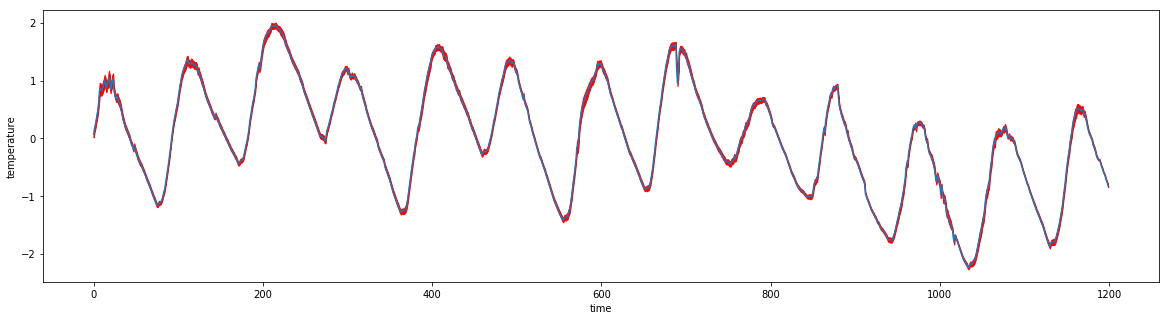

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(mu)
ax.fill_between(np.arange(0, y_hat.shape[0], 1),mu + 1.28*sigma, mu - 1.28*sigma,alpha=1,color='red')
ax.set_xlabel('time')
ax.set_ylabel('temperature')

Text(0, 0.5, 'temperature')

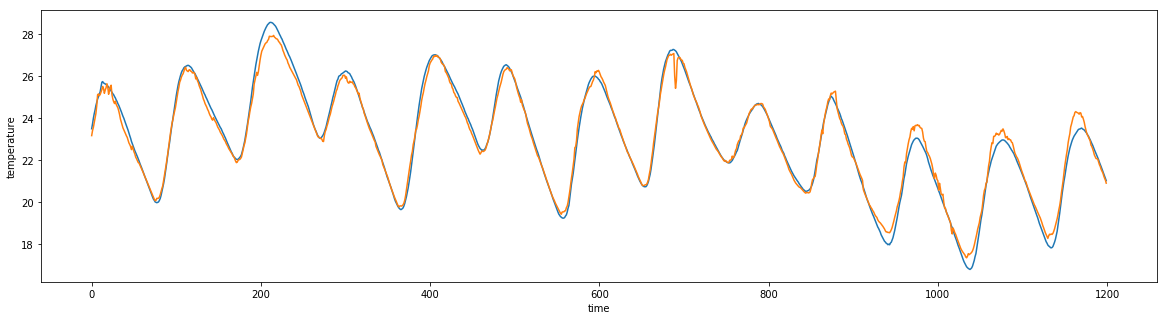

In [51]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(y)
ax.plot(y_hat)
ax.set_xlabel('time')
ax.set_ylabel('temperature')

In [52]:
fig.savefig('np_sml.png')